In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [3]:
# settings for models to solve
T = 10

# Upper envelope not implmented for EGM yet.
specs = {
    'model 1':{'latexname':'vfi', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'do_egm':False,'threads':threads}},
    'model 2':{'latexname':'egm', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'do_egm':True,'threads':threads}},
}

In [4]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    %time models[name].solve()

solving model 1...
Wall time: 9.08 s
solving model 2...
Wall time: 239 ms


# Simulated paths

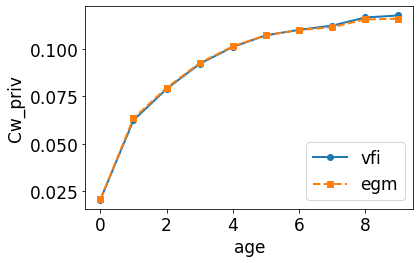

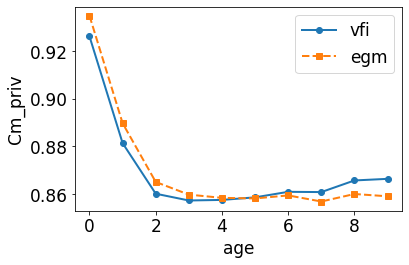

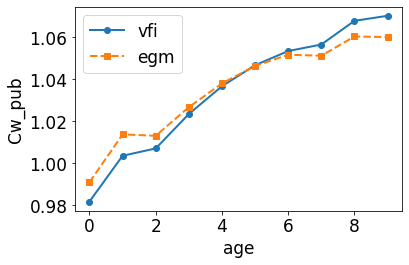

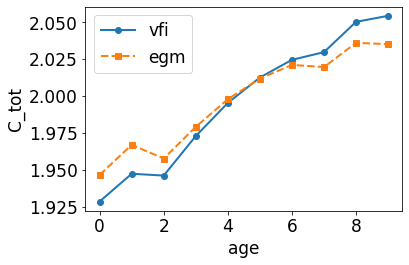

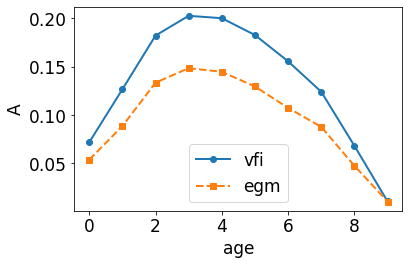

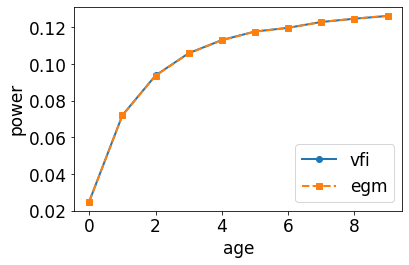

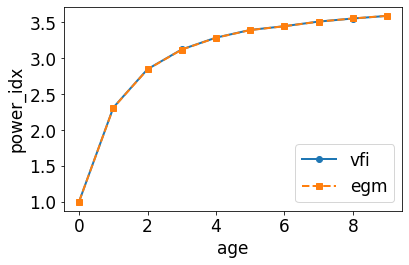

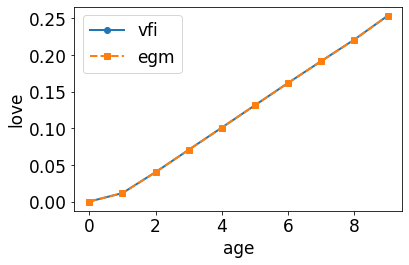

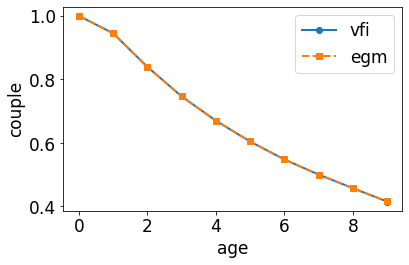

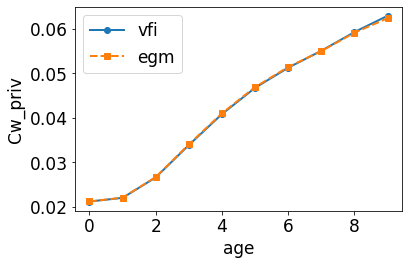

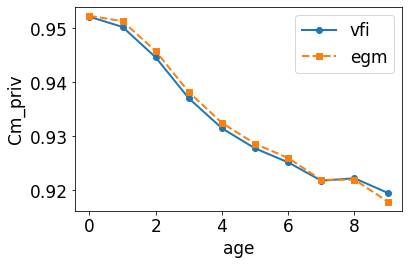

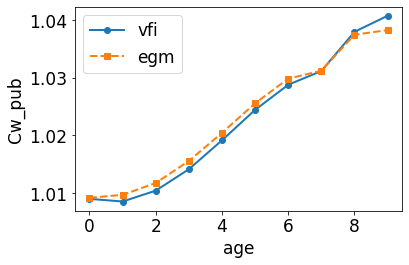

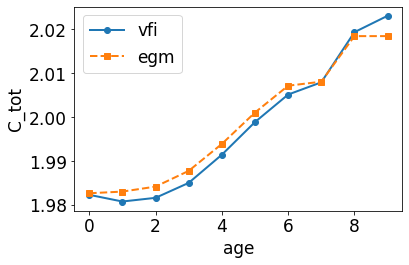

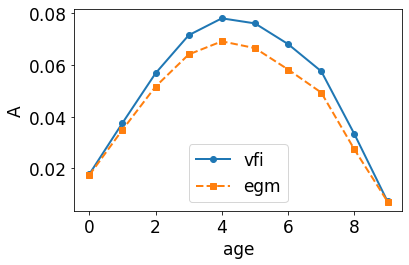

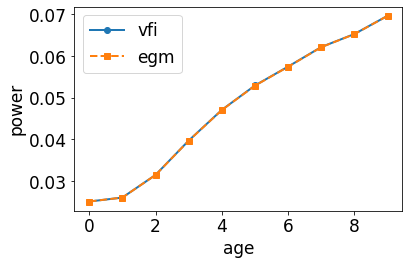

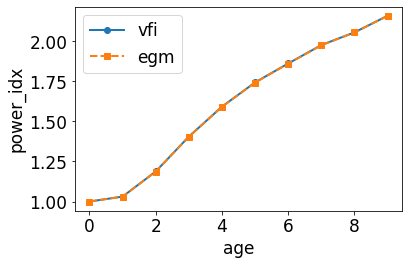

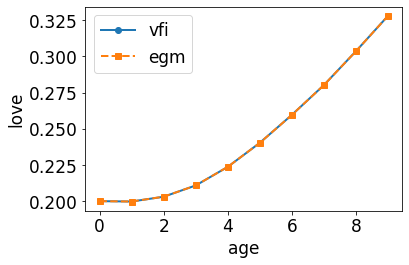

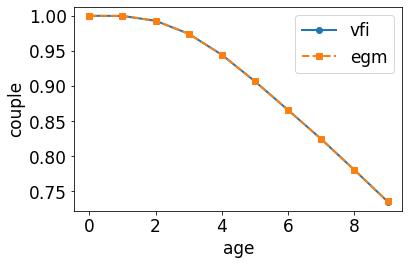

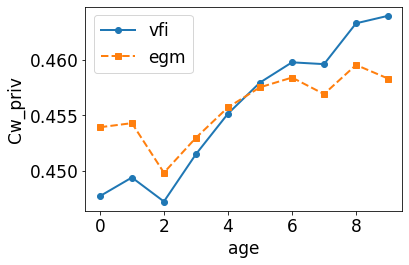

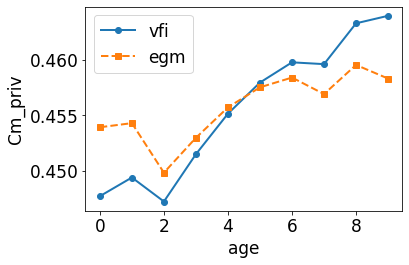

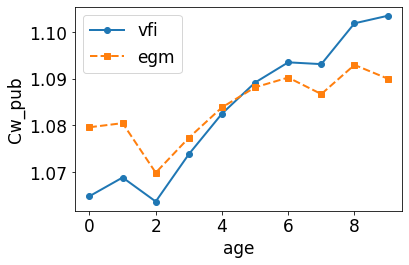

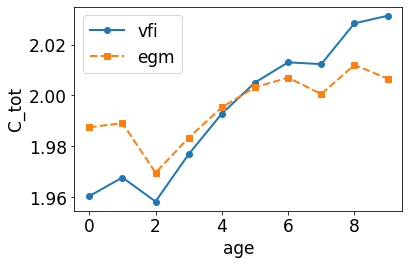

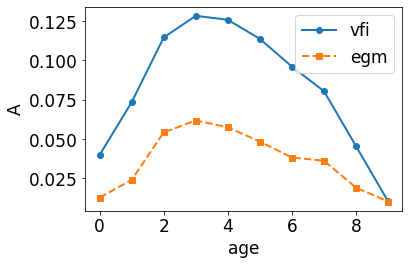

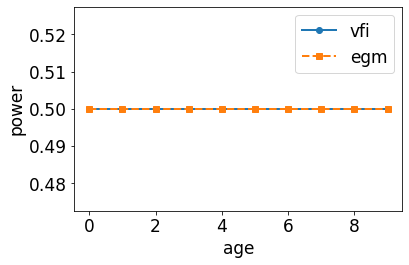

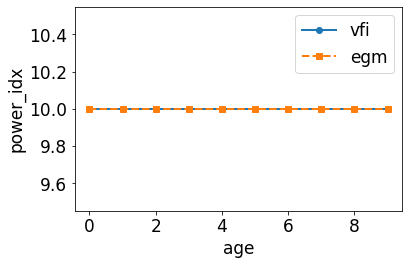

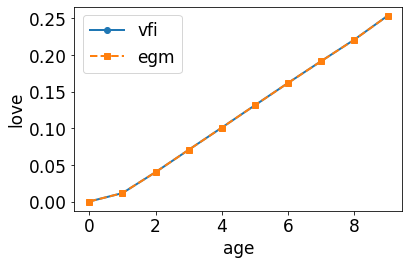

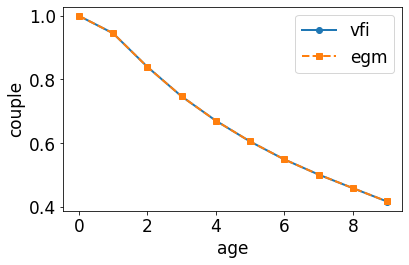

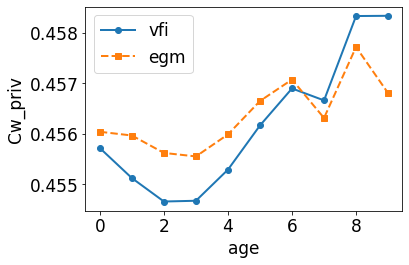

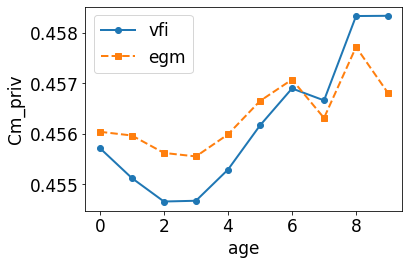

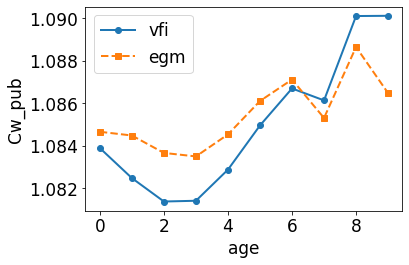

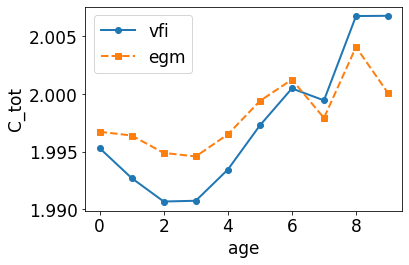

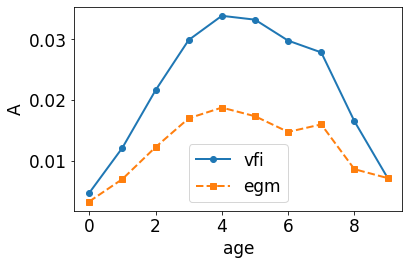

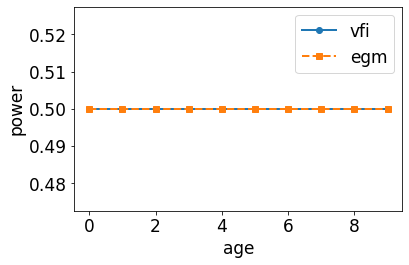

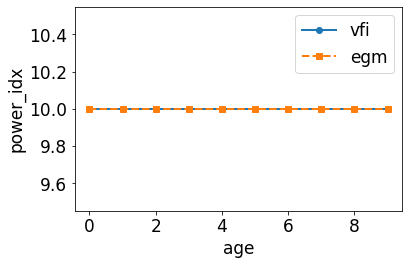

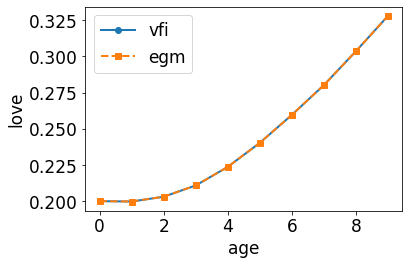

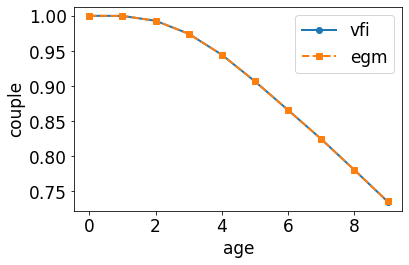

In [5]:
var_list = ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','power_idx','love','couple')
model_list = ('model 1','model 2')

SAVE = False
for init_power_idx in (1,10):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')

# Solution

# Policy functions

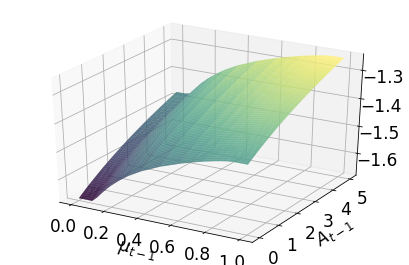

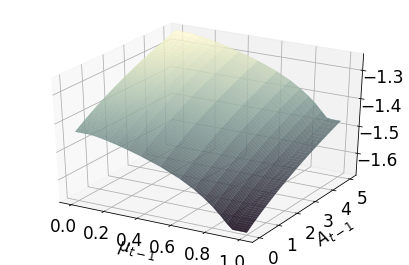

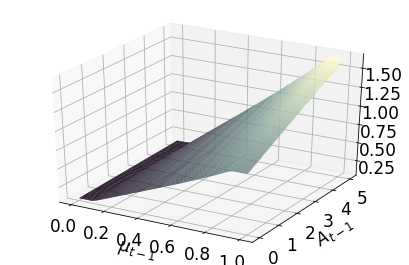

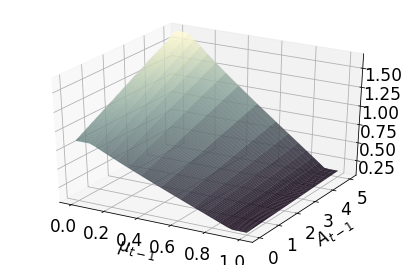

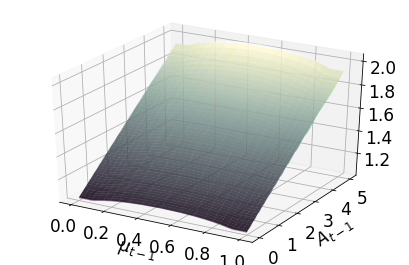

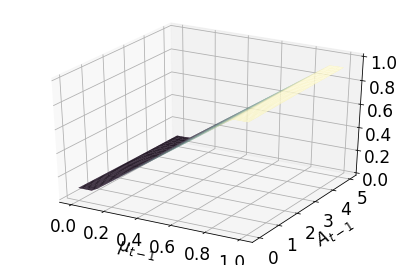

In [6]:
cmaps = ('viridis','gray')
SAVE = False
model_list = ('model 1','model 2')


par = models['model 1'].par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
            
            t = model.par.T-1-2
        
            Z = getattr(model.sol,var)[t,:,iL,:]
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                
                ax.set(zlim=[0.0,1.0])
            
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: plt.savefig(path+fig_name+'.pdf')